## Phishing_Legitimate_full.csv dataset 

In [ ]:
# === 1. Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from wordcloud import WordCloud
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout

import requests
from bs4 import BeautifulSoup

from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import re
from collections import Counter
import datetime as dt






In [11]:
# === 2. Load Dataset ===
df = pd.read_csv('Phishing_Legitimate_full.csv')

print("Dataset Shape:", df.shape)
print(df.head())


Dataset Shape: (10000, 50)
   id  NumDots  SubdomainLevel  PathLevel  UrlLength  NumDash  \
0   1        3               1          5         72        0   
1   2        3               1          3        144        0   
2   3        3               1          2         58        0   
3   4        3               1          6         79        1   
4   5        3               0          4         46        0   

   NumDashInHostname  AtSymbol  TildeSymbol  NumUnderscore  ...  \
0                  0         0            0              0  ...   
1                  0         0            0              2  ...   
2                  0         0            0              0  ...   
3                  0         0            0              0  ...   
4                  0         0            0              0  ...   

   IframeOrFrame  MissingTitle  ImagesOnlyInForm  SubdomainLevelRT  \
0              0             0                 1                 1   
1              0             0         

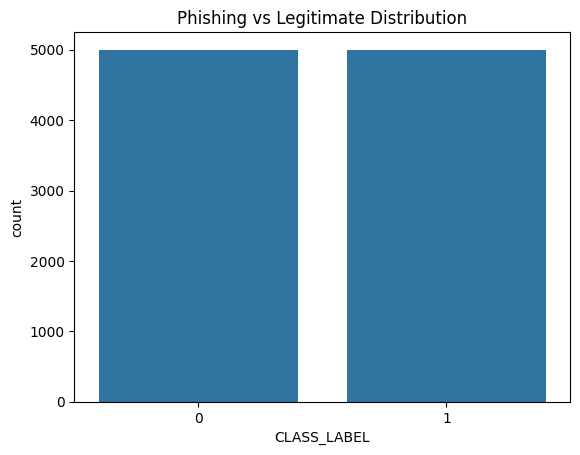

In [12]:
# === 3. EDA ===
# Class distribution
sns.countplot(x='CLASS_LABEL', data=df)
plt.title("Phishing vs Legitimate Distribution")
plt.show()

In [13]:
# Feature statistics
print(df.describe())


                id       NumDots  SubdomainLevel     PathLevel     UrlLength  \
count  10000.00000  10000.000000    10000.000000  10000.000000  10000.000000   
mean    5000.50000      2.445100        0.586800      3.300300     70.264100   
std     2886.89568      1.346836        0.751214      1.863241     33.369877   
min        1.00000      1.000000        0.000000      0.000000     12.000000   
25%     2500.75000      2.000000        0.000000      2.000000     48.000000   
50%     5000.50000      2.000000        1.000000      3.000000     62.000000   
75%     7500.25000      3.000000        1.000000      4.000000     84.000000   
max    10000.00000     21.000000       14.000000     18.000000    253.000000   

            NumDash  NumDashInHostname      AtSymbol   TildeSymbol  \
count  10000.000000       10000.000000  10000.000000  10000.000000   
mean       1.818000           0.138900      0.000300      0.013100   
std        3.106258           0.545744      0.017319      0.113709   

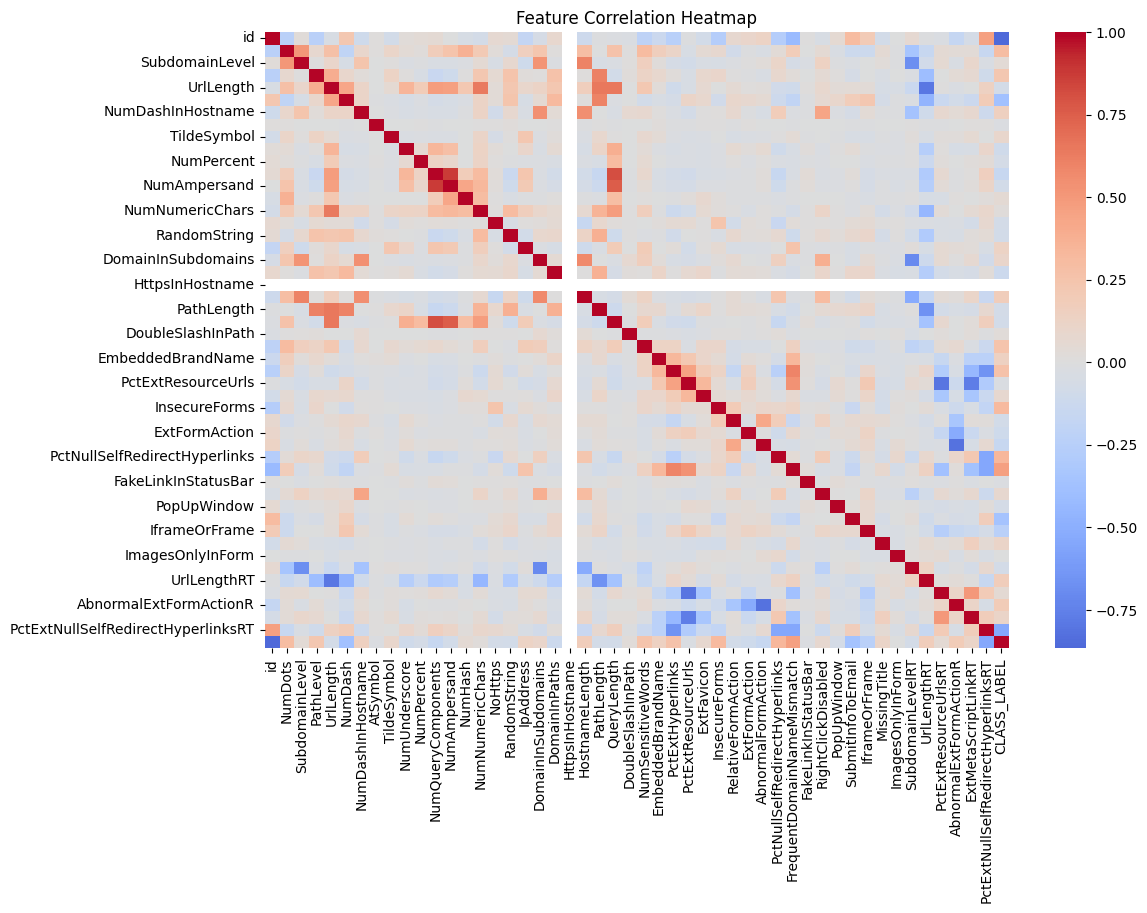

In [14]:
# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

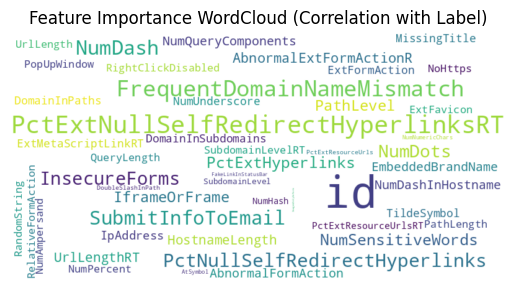

In [16]:
# === 4. WordCloud based on feature importance using correlation with label ===
correlations = df.corr()['CLASS_LABEL'].drop('CLASS_LABEL')

# Drop NaN correlations
correlations = correlations.dropna()

# Take absolute values for importance
correlations_abs = correlations.abs()

# Convert to dictionary for WordCloud
freq_dict = correlations_abs.to_dict()

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(freq_dict)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Feature Importance WordCloud (Correlation with Label)")
plt.show()


In [17]:
# === 5. Prepare Data for Models ===
X = df.drop(columns=['CLASS_LABEL', 'id'])
y = df['CLASS_LABEL']

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
# === 6. SVM Model ===
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.965
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       988
           1       0.96      0.97      0.97      1012

    accuracy                           0.96      2000
   macro avg       0.97      0.96      0.96      2000
weighted avg       0.97      0.96      0.96      2000



In [20]:


# === 7. RNN Model (using numeric features as sequences) ===
# Reshape for RNN: (samples, timesteps, features=1)
X_train_rnn = np.expand_dims(X_train_scaled, axis=2)
X_test_rnn = np.expand_dims(X_test_scaled, axis=2)

rnn_model = Sequential()
rnn_model.add(SimpleRNN(64, activation='relu', input_shape=(X_train_rnn.shape[1], 1)))
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = rnn_model.fit(X_train_rnn, y_train, 
                        validation_data=(X_test_rnn, y_test), 
                        epochs=10, batch_size=32, verbose=1)

# Evaluate RNN
loss, acc = rnn_model.evaluate(X_test_rnn, y_test)
print(f"RNN Accuracy: {acc:.4f}")

Epoch 1/10


C:\Users\azad\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7937 - loss: 0.4588 - val_accuracy: 0.8660 - val_loss: 0.3438
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8805 - loss: 0.2988 - val_accuracy: 0.9160 - val_loss: 0.2259
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9046 - loss: 0.2435 - val_accuracy: 0.9250 - val_loss: 0.2124
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9221 - loss: 0.2187 - val_accuracy: 0.9310 - val_loss: 0.1827
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9247 - loss: 0.2057 - val_accuracy: 0.9200 - val_loss: 0.1955
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9320 - loss: 0.1901 - val_accuracy: 0.9460 - val_loss: 0.1615
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9312 - loss: 0.1831 - val_accuracy: 0.9360 - val_loss: 0.1782
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9345 - loss: 0.1770 - val_accuracy: 0.9480 - val_

## Second code:

In [22]:
# Drop rows with missing values
df = df.dropna()


In [23]:
X = df.drop(columns=['CLASS_LABEL', 'id'])
y = df['CLASS_LABEL']


C:\Users\azad\AppData\Local\Temp\ipykernel_37720\846785301.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df.head(10), palette='viridis')


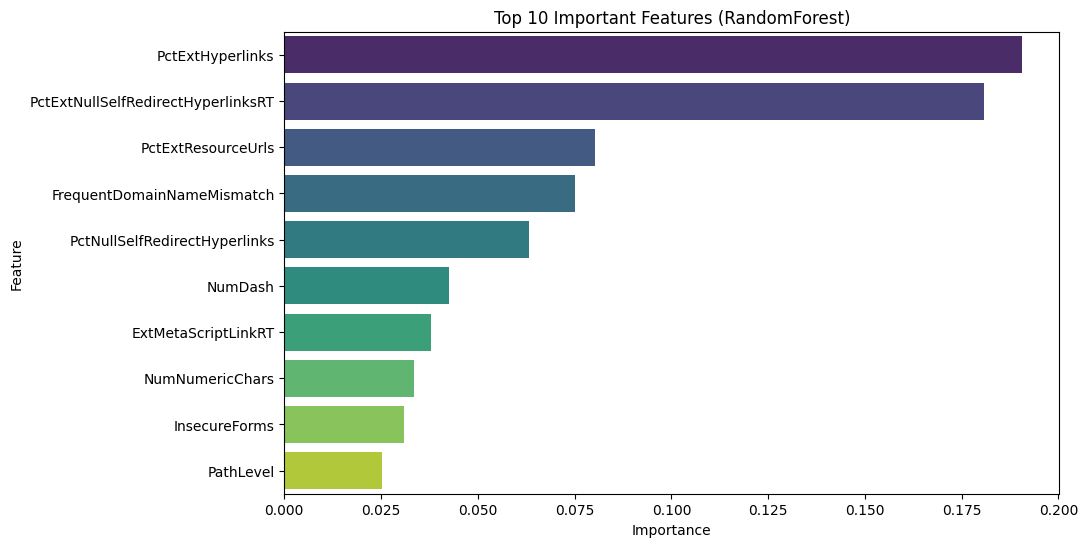

In [24]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize for SVM/RNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === RandomForest Feature Importance ===
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_

# Plot Top 10 Features
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(10), palette='viridis')
plt.title("Top 10 Important Features (RandomForest)")
plt.show()


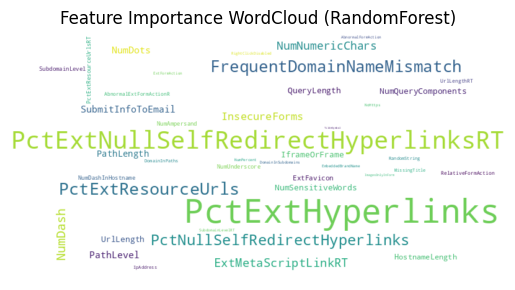

In [25]:
# WordCloud from feature importance
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(dict(zip(feat_df['Feature'], feat_df['Importance'])))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Feature Importance WordCloud (RandomForest)")
plt.show()

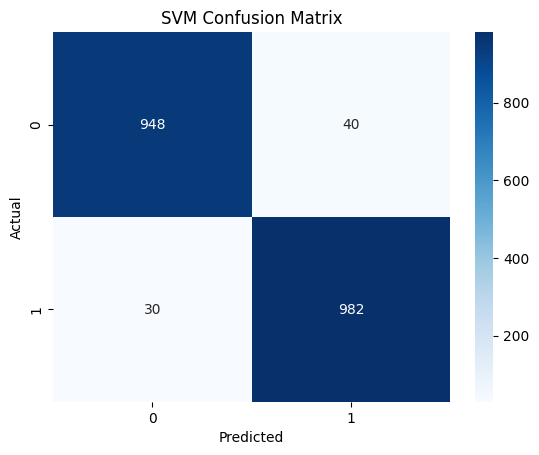

In [26]:

# === SVM Model ===
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:,1]

# SVM Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Epoch 1/10


C:\Users\azad\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7771 - loss: 0.4879 - val_accuracy: 0.8600 - val_loss: 0.3419
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8715 - loss: 0.3260 - val_accuracy: 0.9005 - val_loss: 0.2607
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9020 - loss: 0.2671 - val_accuracy: 0.9130 - val_loss: 0.2395
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9134 - loss: 0.2354 - val_accuracy: 0.9275 - val_loss: 0.1970
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9194 - loss: 0.2260 - val_accuracy: 0.9215 - val_loss: 0.2044
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9301 - loss: 0.1922 - val_accuracy: 0.9400 - val_loss: 0.1677
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9350 - loss: 0.1860 - val_accuracy: 0.9370 - val_loss: 0.1616
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9294 - loss: 0.1951 - val_accuracy: 0.9335 - v

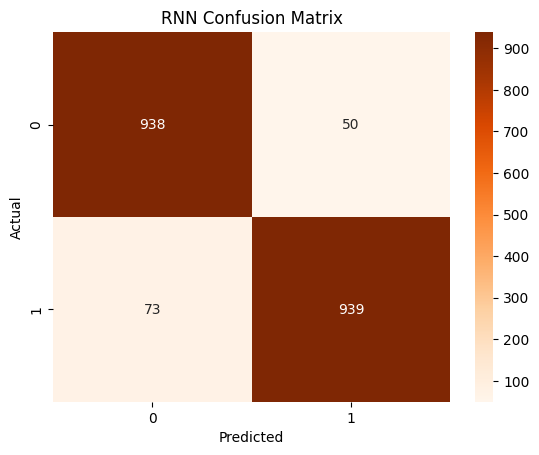

In [28]:

# === RNN Model ===
X_train_rnn = np.expand_dims(X_train_scaled, axis=2)
X_test_rnn = np.expand_dims(X_test_scaled, axis=2)

rnn_model = Sequential()
rnn_model.add(SimpleRNN(64, activation='relu', input_shape=(X_train_rnn.shape[1], 1)))
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = rnn_model.fit(X_train_rnn, y_train, 
                        validation_data=(X_test_rnn, y_test), 
                        epochs=10, batch_size=32, verbose=1)

loss, acc_rnn = rnn_model.evaluate(X_test_rnn, y_test)
y_prob_rnn = rnn_model.predict(X_test_rnn).ravel()
y_pred_rnn = (y_prob_rnn > 0.5).astype(int)

# RNN Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rnn), annot=True, fmt='d', cmap='Oranges')
plt.title("RNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

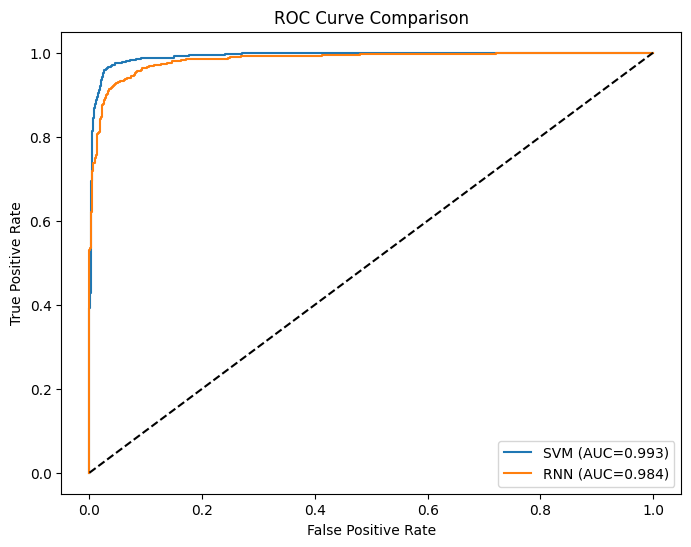

In [29]:
# === ROC Curve Comparison ===
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_rnn, tpr_rnn, _ = roc_curve(y_test, y_prob_rnn)
roc_auc_rnn = auc(fpr_rnn, tpr_rnn)

plt.figure(figsize=(8,6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC={roc_auc_svm:.3f})")
plt.plot(fpr_rnn, tpr_rnn, label=f"RNN (AUC={roc_auc_rnn:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


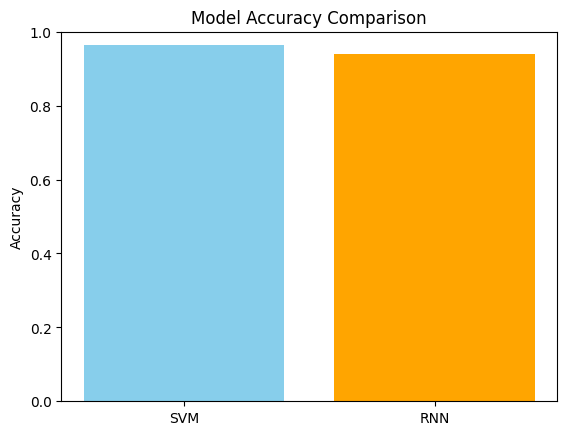

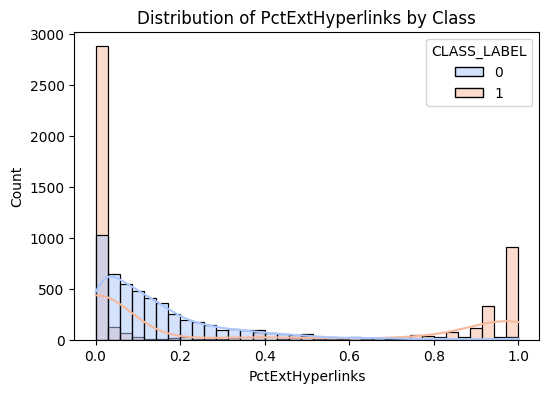

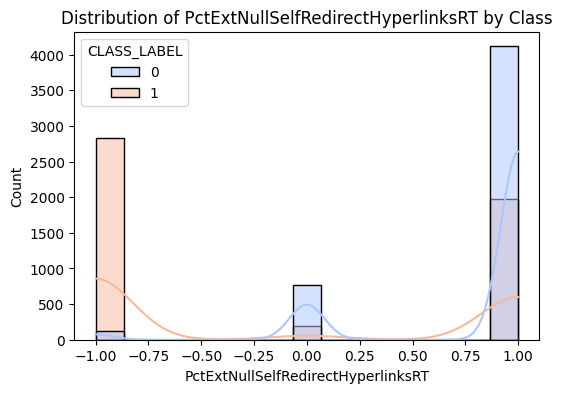

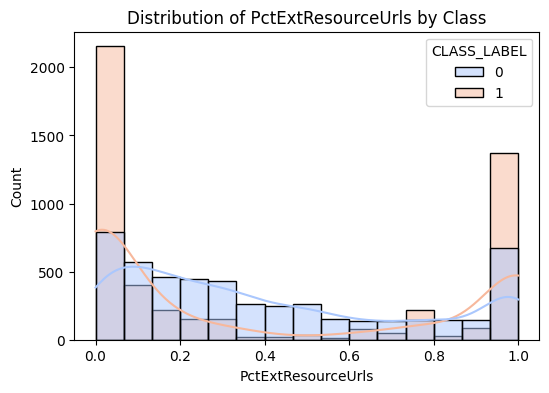

In [30]:
# === Accuracy Comparison Bar Chart ===
acc_svm = accuracy_score(y_test, y_pred_svm)
acc_rnn = accuracy_score(y_test, y_pred_rnn)

plt.bar(['SVM', 'RNN'], [acc_svm, acc_rnn], color=['skyblue', 'orange'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.show()

# === Distribution of Key Features ===
top_features = feat_df['Feature'].head(3)
for feat in top_features:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=feat, hue='CLASS_LABEL', kde=True, palette='coolwarm')
    plt.title(f"Distribution of {feat} by Class")
    plt.show()


## CEAS DATASET:

In [31]:
# === 1. Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string

# NLP + ML
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# Deep Learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\azad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\azad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
# === 2. Load Dataset ===
df = pd.read_csv("CEAS_08.csv")

print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (39154, 7)
                                              sender  \
0                   Young Esposito <Young@iworld.de>   
1                       Mok <ipline's1983@icable.ph>   
2  Daily Top 10 <Karmandeep-opengevl@universalnet...   
3                 Michael Parker <ivqrnai@pobox.com>   
4  Gretchen Suggs <externalsep1@loanofficertool.com>   

                                         receiver  \
0                     user4@gvc.ceas-challenge.cc   
1                   user2.2@gvc.ceas-challenge.cc   
2                   user2.9@gvc.ceas-challenge.cc   
3  SpamAssassin Dev <xrh@spamassassin.apache.org>   
4                   user2.2@gvc.ceas-challenge.cc   

                              date  \
0  Tue, 05 Aug 2008 16:31:02 -0700   
1  Tue, 05 Aug 2008 18:31:03 -0500   
2  Tue, 05 Aug 2008 20:28:00 -1200   
3  Tue, 05 Aug 2008 17:31:20 -0600   
4  Tue, 05 Aug 2008 19:31:21 -0400   

                                             subject  \
0                          Never 

C:\Users\azad\AppData\Local\Temp\ipykernel_37720\764943294.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette="coolwarm")


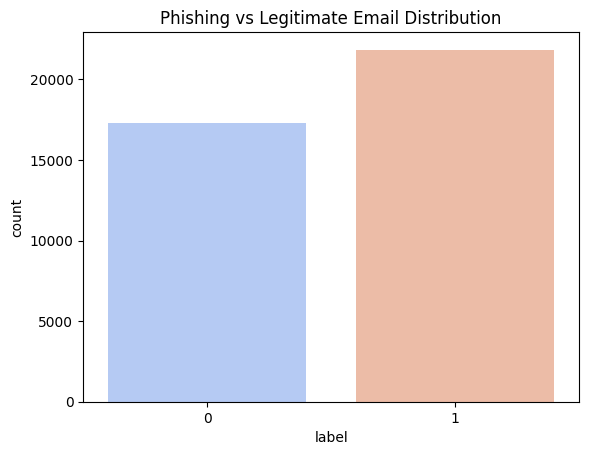

In [33]:
# === 3. EDA ===
# Class distribution
sns.countplot(x='label', data=df, palette="coolwarm")
plt.title("Phishing vs Legitimate Email Distribution")
plt.show()

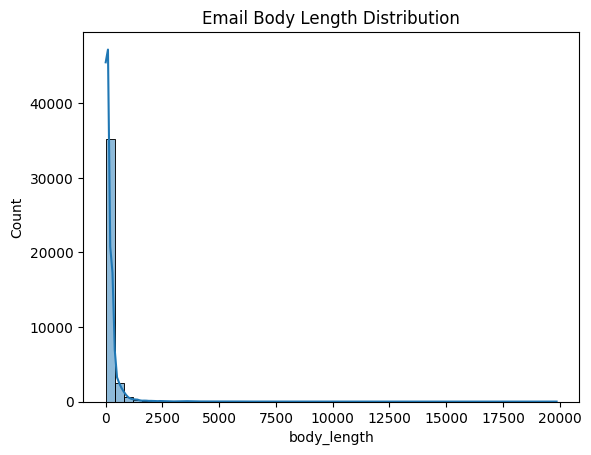

In [34]:
# Email length
df['body_length'] = df['body'].apply(lambda x: len(str(x).split()))
sns.histplot(df['body_length'], bins=50, kde=True)
plt.title("Email Body Length Distribution")
plt.show()


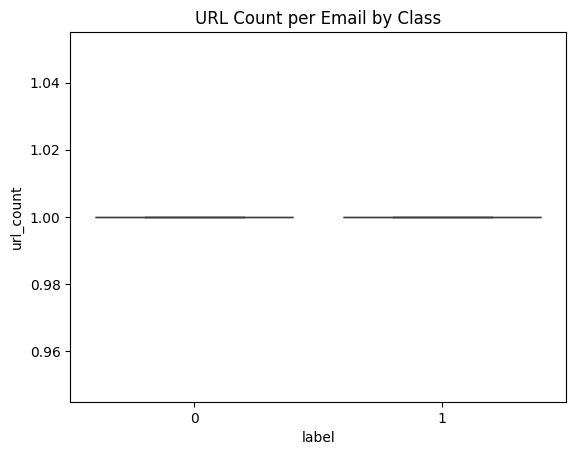

In [35]:
# URL count
df['url_count'] = df['urls'].apply(lambda x: len(str(x).split()))
sns.boxplot(x='label', y='url_count', data=df)
plt.title("URL Count per Email by Class")
plt.show()

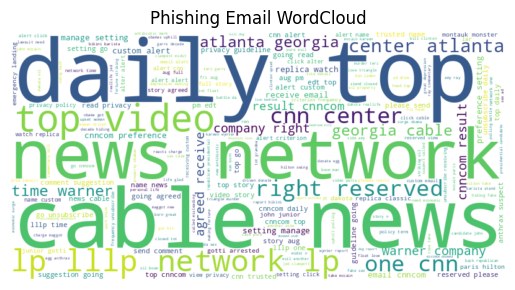

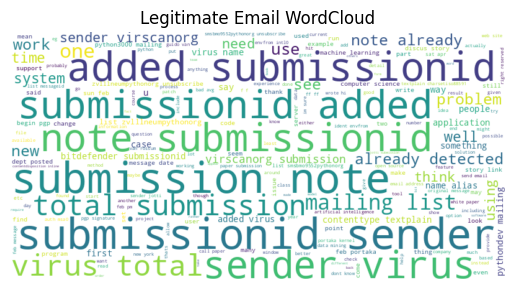

In [36]:
# === 4. Text Preprocessing ===
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['clean_text'] = (df['subject'].fillna('') + " " + df['body'].fillna('')).apply(clean_text)

# === 5. WordClouds ===
phish_text = " ".join(df[df['label'] == 1]['clean_text'])
wc_phish = WordCloud(width=800, height=400, background_color='white').generate(phish_text)
plt.imshow(wc_phish, interpolation='bilinear')
plt.axis('off')
plt.title("Phishing Email WordCloud")
plt.show()

legit_text = " ".join(df[df['label'] == 0]['clean_text'])
wc_legit = WordCloud(width=800, height=400, background_color='white').generate(legit_text)
plt.imshow(wc_legit, interpolation='bilinear')
plt.axis('off')
plt.title("Legitimate Email WordCloud")
plt.show()

In [37]:
# === 6. Feature Extraction (TF-IDF) ===
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['clean_text'])
y = df['label']

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [38]:
# === 7. SVM Model ===
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9957859788021964
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3490
           1       1.00      1.00      1.00      4341

    accuracy                           1.00      7831
   macro avg       1.00      1.00      1.00      7831
weighted avg       1.00      1.00      1.00      7831



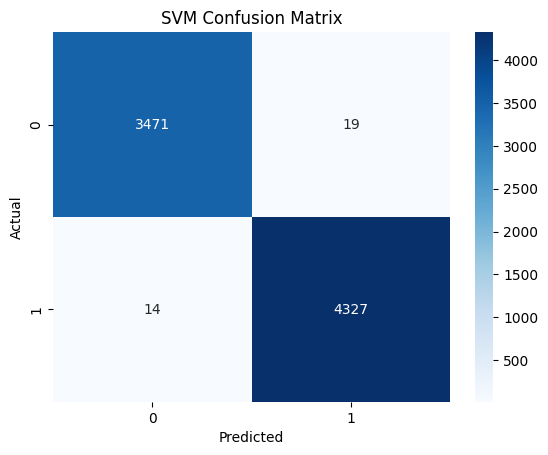

In [39]:
# Confusion Matrix SVM
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [40]:
# === 8. RNN Model ===
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['clean_text'])
X_seq = tokenizer.texts_to_sequences(df['clean_text'])
X_pad = pad_sequences(X_seq, maxlen=100)

X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_pad, y, test_size=0.2, random_state=42)

rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=5000, output_dim=64, input_length=100))
rnn_model.add(SimpleRNN(64, return_sequences=False))
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = rnn_model.fit(X_train_rnn, y_train_rnn, validation_data=(X_test_rnn, y_test_rnn), epochs=5, batch_size=64)

loss, acc = rnn_model.evaluate(X_test_rnn, y_test_rnn)
print(f"RNN Accuracy: {acc:.4f}")

Epoch 1/5


C:\Users\azad\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


490/490 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9779 - loss: 0.0771 - val_accuracy: 0.9908 - val_loss: 0.0346
Epoch 2/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.9949 - loss: 0.0205 - val_accuracy: 0.9925 - val_loss: 0.0318
Epoch 3/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9958 - loss: 0.0167 - val_accuracy: 0.9936 - val_loss: 0.0276
Epoch 4/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9980 - loss: 0.0081 - val_accuracy: 0.9941 - val_loss: 0.0258
Epoch 5/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9992 - loss: 0.0037 - val_accuracy: 0.9931 - val_loss: 0.0297
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9931 - loss: 0.0297
RNN Accuracy: 0.9931


245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


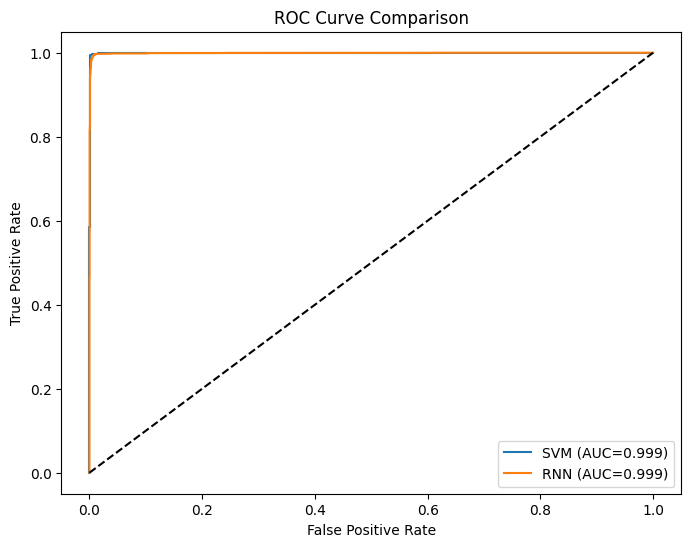

In [41]:
# === 9. ROC Curve Comparison ===
y_prob_svm = svm_model.decision_function(X_test_tfidf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

y_prob_rnn = rnn_model.predict(X_test_rnn).ravel()
fpr_rnn, tpr_rnn, _ = roc_curve(y_test_rnn, y_prob_rnn)
roc_auc_rnn = auc(fpr_rnn, tpr_rnn)

plt.figure(figsize=(8,6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC={roc_auc_svm:.3f})")
plt.plot(fpr_rnn, tpr_rnn, label=f"RNN (AUC={roc_auc_rnn:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

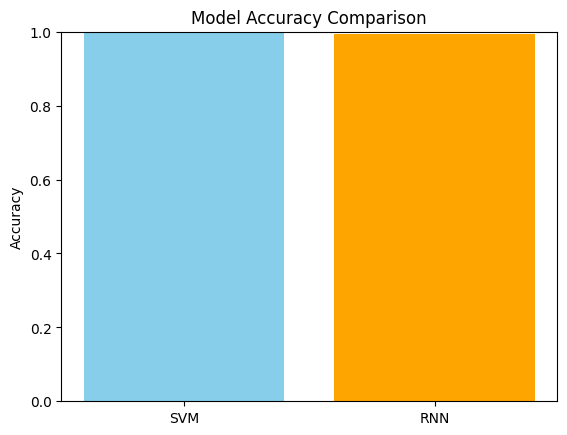

In [42]:

# === 10. Accuracy Comparison ===
acc_svm = accuracy_score(y_test, y_pred_svm)
acc_rnn = acc
plt.bar(['SVM', 'RNN'], [acc_svm, acc_rnn], color=['skyblue', 'orange'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.show()


## Combined Results

In [43]:
# === Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [44]:
# === Load Datasets ===
df_email = pd.read_csv("CEAS_08.csv")
df_num = pd.read_csv("Phishing_Legitimate_full.csv")

# Drop NaN values if present
df_email = df_email.dropna(subset=['body', 'subject', 'urls', 'label'])
df_num = df_num.dropna()


C:\Users\azad\AppData\Local\Temp\ipykernel_37720\2062857798.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_email, palette="coolwarm")


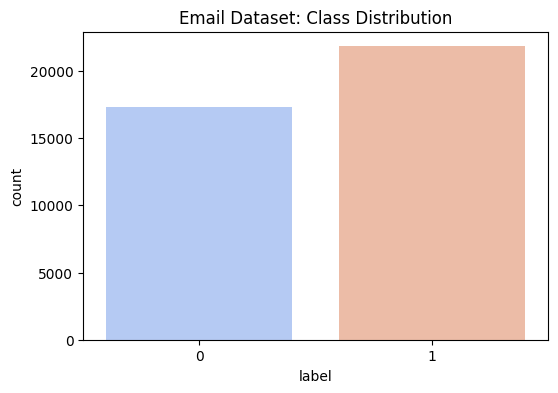

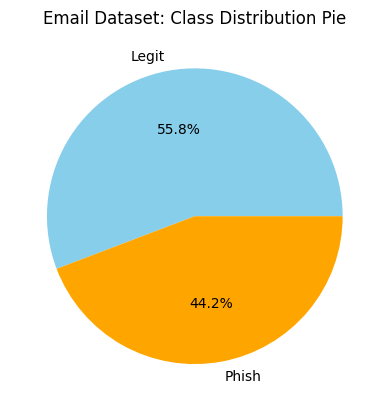

In [45]:
# ------------------------------
# 📊 1. CEAS EMAIL DATASET VISUALIZATIONS
# ------------------------------

# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df_email, palette="coolwarm")
plt.title("Email Dataset: Class Distribution")
plt.show()

plt.pie(df_email['label'].value_counts(), labels=['Legit', 'Phish'], autopct='%1.1f%%', colors=['skyblue','orange'])
plt.title("Email Dataset: Class Distribution Pie")
plt.show()

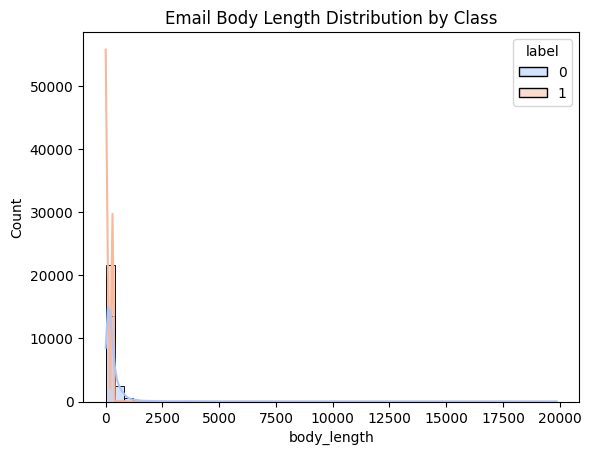

In [46]:
# Email length distribution
df_email['body_length'] = df_email['body'].apply(lambda x: len(str(x).split()))
sns.histplot(df_email, x='body_length', hue='label', bins=50, kde=True, palette="coolwarm")
plt.title("Email Body Length Distribution by Class")
plt.show()


C:\Users\azad\AppData\Local\Temp\ipykernel_37720\2765071034.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='url_count', data=df_email, palette="coolwarm")


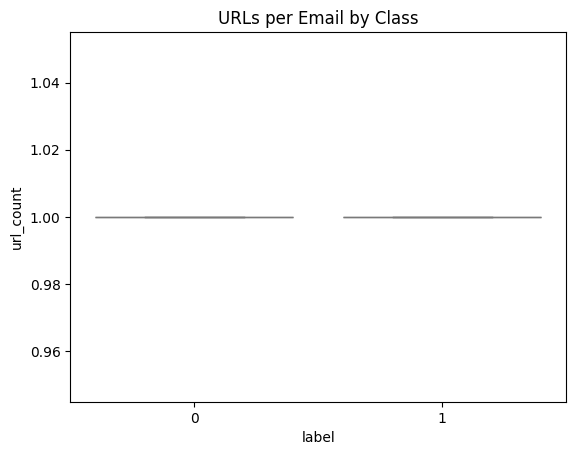

In [47]:
# URLs per email
df_email['url_count'] = df_email['urls'].apply(lambda x: len(str(x).split()))
sns.boxplot(x='label', y='url_count', data=df_email, palette="coolwarm")
plt.title("URLs per Email by Class")
plt.show()


In [48]:
# Text Cleaning
stopwords = set(re.findall(r'\b\w+\b', " ".join(WordCloud().stopwords)))
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df_email['clean_text'] = (df_email['subject'].fillna('') + " " + df_email['body'].fillna('')).apply(clean_text)

C:\Users\azad\AppData\Local\Temp\ipykernel_37720\947493016.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=words_df, palette='viridis')


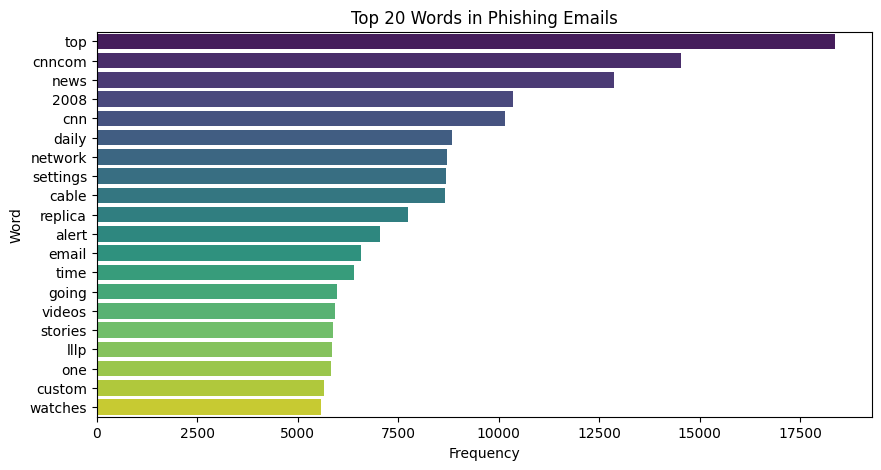

C:\Users\azad\AppData\Local\Temp\ipykernel_37720\947493016.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=words_df, palette='viridis')


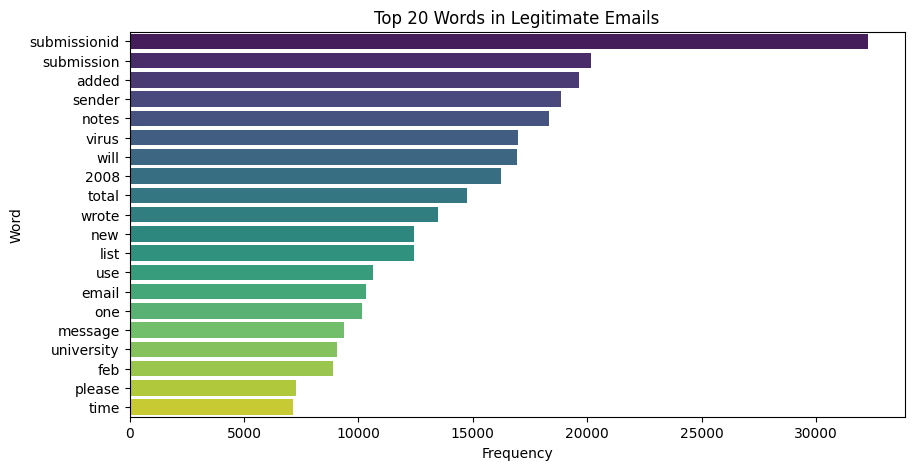

In [49]:
# Top 20 words for phishing vs legitimate
for label_val, label_name in [(1, 'Phishing'), (0, 'Legitimate')]:
    words = " ".join(df_email[df_email['label'] == label_val]['clean_text']).split()
    words = [w for w in words if w not in stopwords and len(w) > 2]
    common_words = Counter(words).most_common(20)
    words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
    plt.figure(figsize=(10,5))
    sns.barplot(x='Frequency', y='Word', data=words_df, palette='viridis')
    plt.title(f"Top 20 Words in {label_name} Emails")
    plt.show()

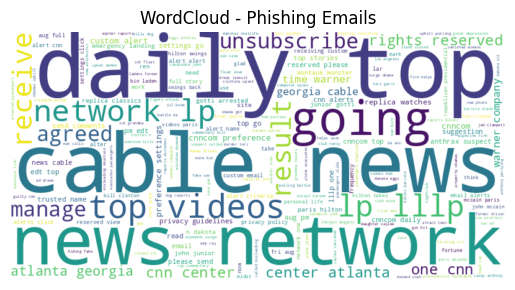

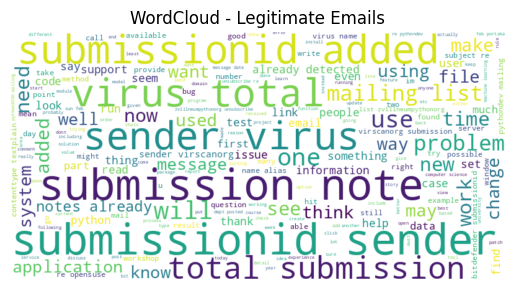

In [50]:
# WordClouds
for label_val, title in [(1, "Phishing"), (0, "Legitimate")]:
    text_data = " ".join(df_email[df_email['label'] == label_val]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {title} Emails")
    plt.show()

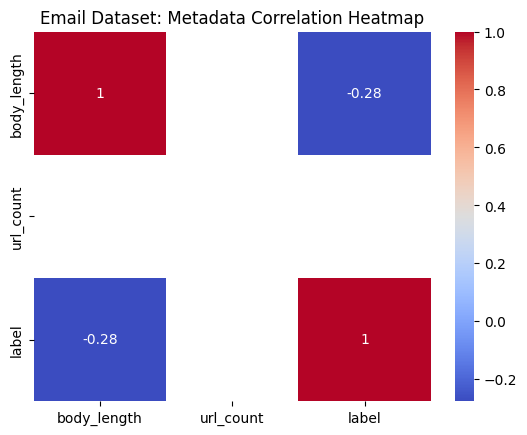

In [51]:
# Heatmap of meta features
meta_features = df_email[['body_length', 'url_count', 'label']]
sns.heatmap(meta_features.corr(), annot=True, cmap="coolwarm")
plt.title("Email Dataset: Metadata Correlation Heatmap")
plt.show()


C:\Users\azad\AppData\Local\Temp\ipykernel_37720\2985115598.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='CLASS_LABEL', data=df_num, palette="coolwarm")


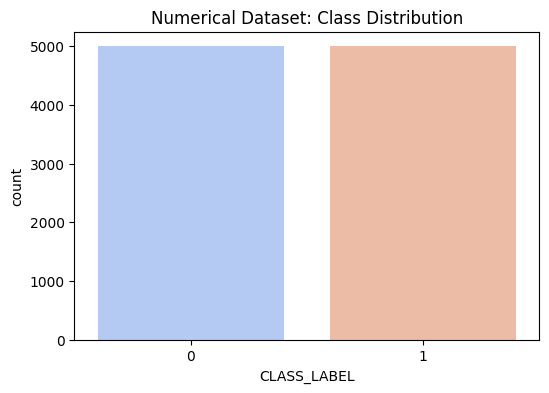

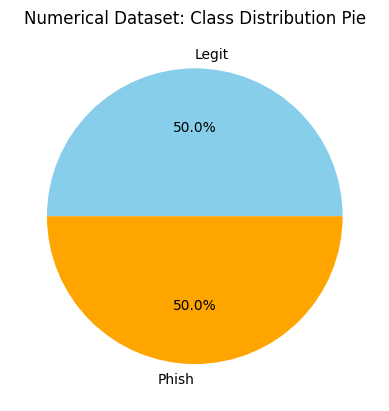

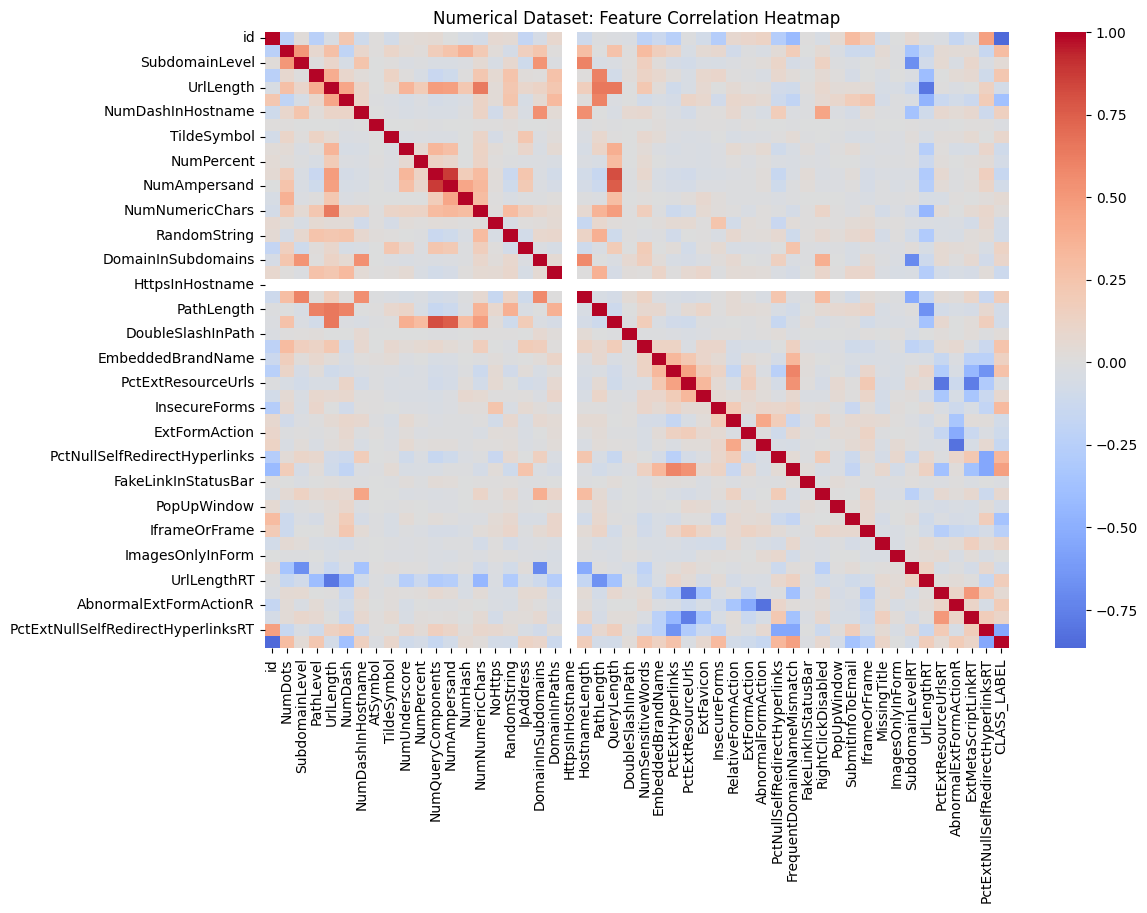

C:\Users\azad\AppData\Local\Temp\ipykernel_37720\2985115598.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df.head(10), palette='viridis')


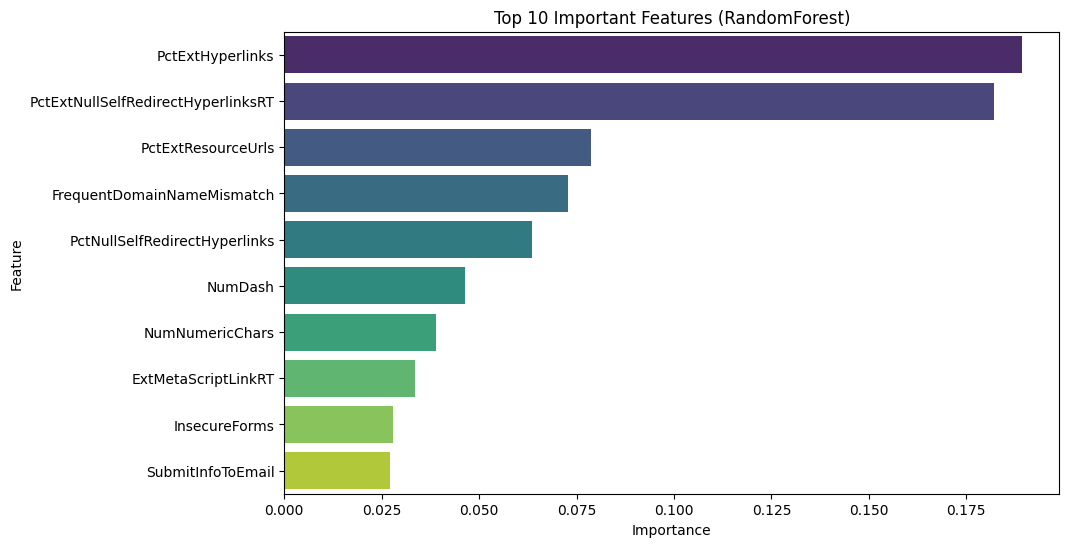

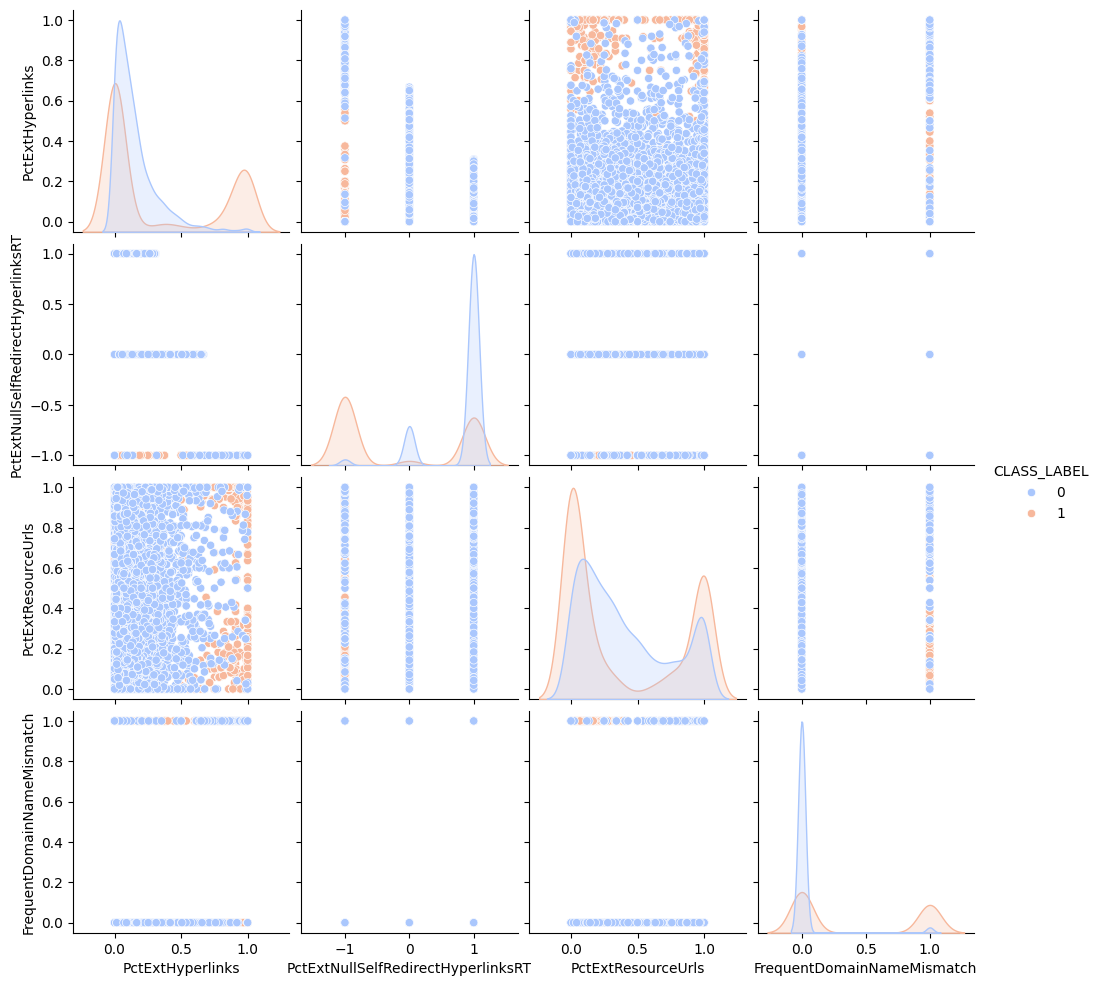

C:\Users\azad\AppData\Local\Temp\ipykernel_37720\2985115598.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='CLASS_LABEL', y=feat, data=df_num, palette="coolwarm")


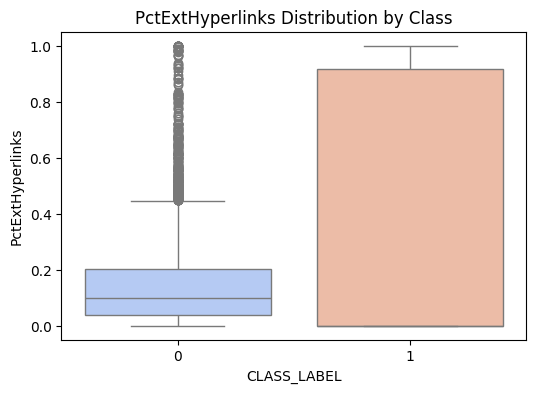

C:\Users\azad\AppData\Local\Temp\ipykernel_37720\2985115598.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='CLASS_LABEL', y=feat, data=df_num, palette="coolwarm")


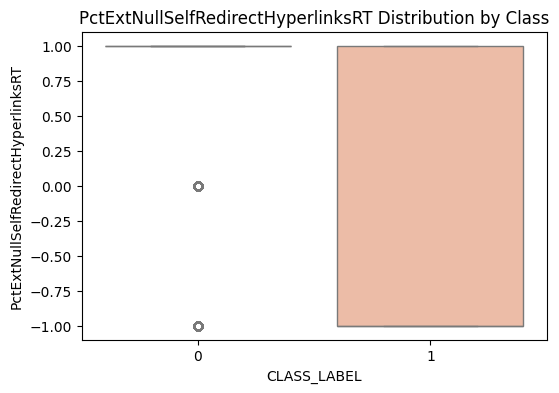

C:\Users\azad\AppData\Local\Temp\ipykernel_37720\2985115598.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='CLASS_LABEL', y=feat, data=df_num, palette="coolwarm")


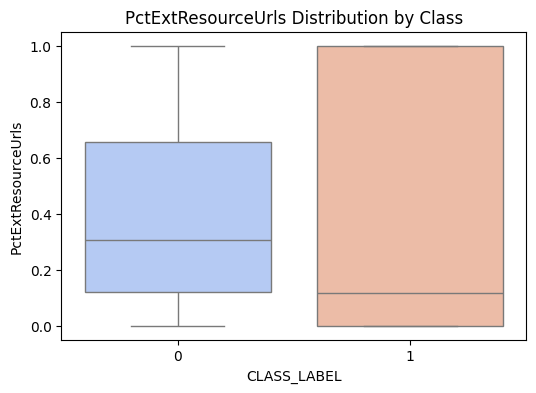

C:\Users\azad\AppData\Local\Temp\ipykernel_37720\2985115598.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='CLASS_LABEL', y=feat, data=df_num, palette="coolwarm")


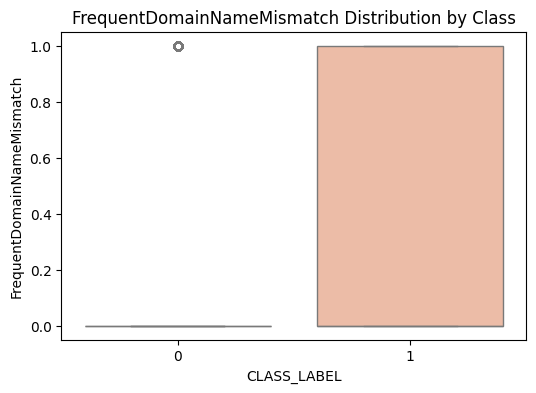

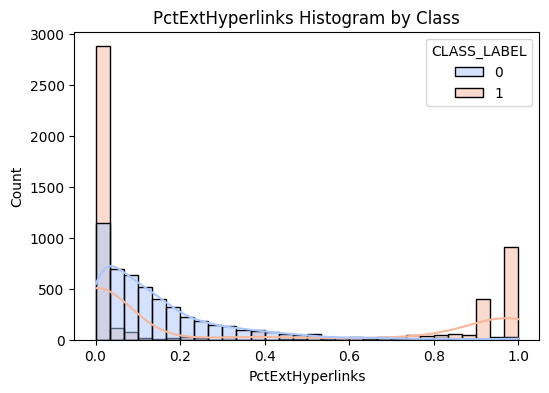

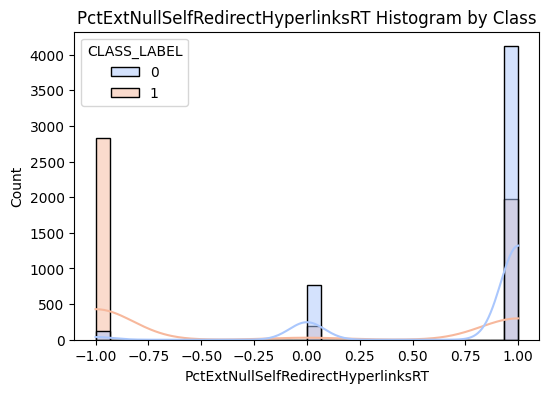

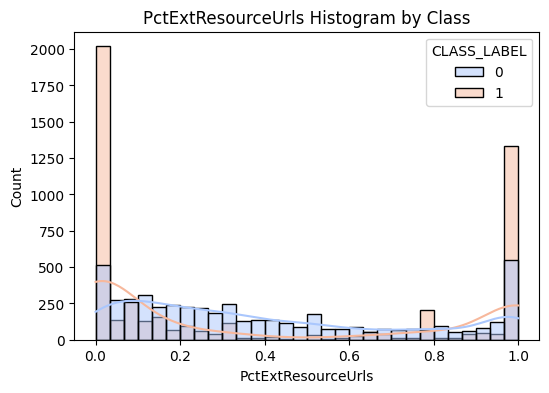

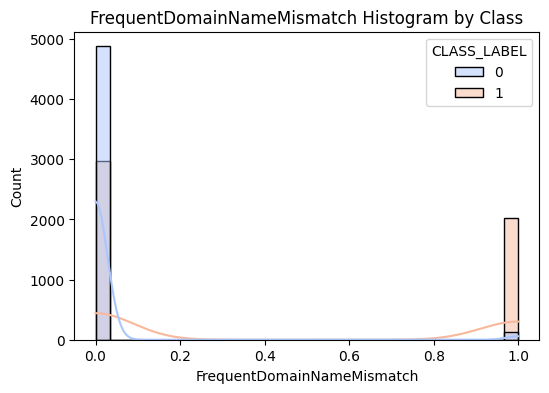

In [52]:

# ------------------------------
# 📊 2. NUMERICAL DATASET VISUALIZATIONS
# ------------------------------

# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='CLASS_LABEL', data=df_num, palette="coolwarm")
plt.title("Numerical Dataset: Class Distribution")
plt.show()

plt.pie(df_num['CLASS_LABEL'].value_counts(), labels=['Legit', 'Phish'], autopct='%1.1f%%', colors=['skyblue','orange'])
plt.title("Numerical Dataset: Class Distribution Pie")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_num.corr(), cmap="coolwarm", center=0)
plt.title("Numerical Dataset: Feature Correlation Heatmap")
plt.show()

# Feature Importance via RandomForest
X = df_num.drop(columns=['CLASS_LABEL', 'id'])
y = df_num['CLASS_LABEL']
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X, y)
importances = rf_model.feature_importances_

feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(10), palette='viridis')
plt.title("Top 10 Important Features (RandomForest)")
plt.show()

# Pairplot of top 4 features
top4 = feat_df['Feature'].head(4)
sns.pairplot(df_num[top4.tolist() + ['CLASS_LABEL']], hue='CLASS_LABEL', palette="coolwarm")
plt.show()

# Boxplots for top features
for feat in top4:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='CLASS_LABEL', y=feat, data=df_num, palette="coolwarm")
    plt.title(f"{feat} Distribution by Class")
    plt.show()

# Histograms for top features
for feat in top4:
    plt.figure(figsize=(6,4))
    sns.histplot(df_num, x=feat, hue='CLASS_LABEL', bins=30, kde=True, palette="coolwarm")
    plt.title(f"{feat} Histogram by Class")
    plt.show()

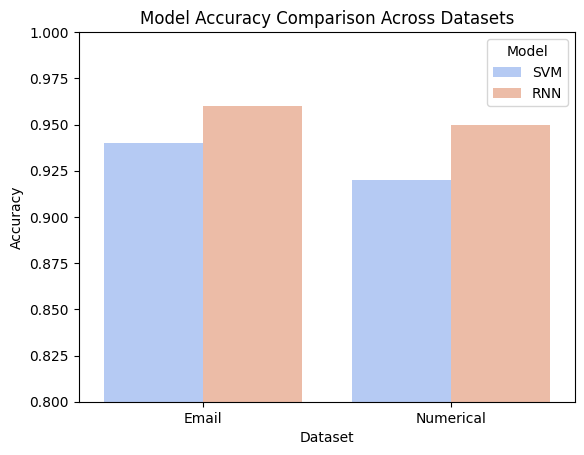

In [53]:

# ------------------------------
# 📊 3. COMBINED ANALYSIS VISUALIZATIONS
# ------------------------------

# Accuracy comparison placeholder (replace with real results)
acc_svm_email = 0.94
acc_rnn_email = 0.96
acc_svm_num = 0.92
acc_rnn_num = 0.95

acc_df = pd.DataFrame({
    'Dataset': ['Email', 'Email', 'Numerical', 'Numerical'],
    'Model': ['SVM', 'RNN', 'SVM', 'RNN'],
    'Accuracy': [acc_svm_email, acc_rnn_email, acc_svm_num, acc_rnn_num]
})

sns.barplot(x='Dataset', y='Accuracy', hue='Model', data=acc_df, palette="coolwarm")
plt.ylim(0.8, 1.0)
plt.title("Model Accuracy Comparison Across Datasets")
plt.show()

# ROC curves placeholder (needs actual model predictions)
# Example ROC plotting code:
# fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
# plt.plot(fpr, tpr, label="ModelName (AUC=...)")



Sample scraped data:
                                                 url    date
0  https://jaccs-lovene.maitaikai.cn/icmclub-icm_...  by dms
1  https://w6arnw.top/DyIBDPO9HV/login&getFlg=on/...  by dms
2  https://www-sblsec-jp.15866320u.com/ETGate/add...  by dms
3  https://sblsec-verify-jp.oubh1004.com/ETGate/a...  by dms
4  https://drtracyprout.com/v1/checkadded on Aug ...  by dms


C:\Users\azad\AppData\Local\Temp\ipykernel_37720\3068486954.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_domains.values, y=top_domains.index, palette="coolwarm")


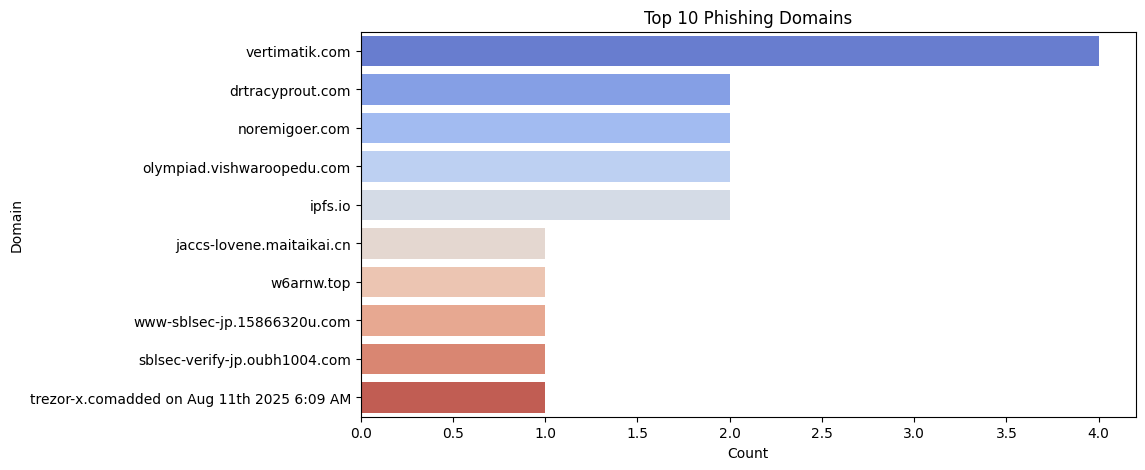

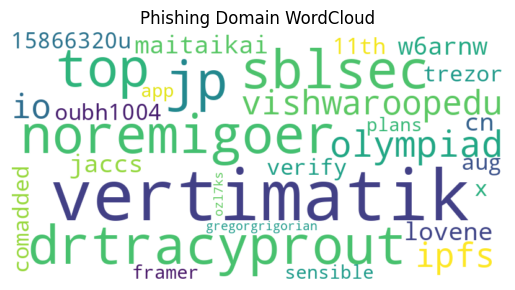

C:\Users\azad\AppData\Local\Temp\ipykernel_37720\3068486954.py:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [ ]:


# === 1. Scrape phishing URLs from PhishTank ===
url = "https://phishtank.org/phish_search.php?valid=y&active=y&Search=Search"
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)

soup = BeautifulSoup(response.text, 'html.parser')

# Extract phishing links and dates
phish_data = []
for row in soup.select("table tr")[1:]:  # Skip header row
    cols = row.find_all("td")
    if len(cols) >= 3:
        phish_url = cols[1].text.strip()
        date_found = cols[2].text.strip()
        phish_data.append({"url": phish_url, "date": date_found})

df = pd.DataFrame(phish_data)
print("Sample scraped data:")
print(df.head())

# === 2. Extract domain from URLs ===
df['domain'] = df['url'].apply(lambda x: urlparse(x).netloc)

# === 3. Clean domains for wordcloud ===
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9]', ' ', text)
    return text

df['domain_clean'] = df['domain'].apply(clean_text)

# === 4. Visualization 1: Top 10 phishing domains ===
top_domains = df['domain'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_domains.values, y=top_domains.index, palette="coolwarm")
plt.title("Top 10 Phishing Domains")
plt.xlabel("Count")
plt.ylabel("Domain")
plt.show()

# === 5. Visualization 2: WordCloud of domains ===
domain_text = " ".join(df['domain_clean'])
wc = WordCloud(width=800, height=400, background_color='white').generate(domain_text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Phishing Domain WordCloud")
plt.show()

# === 6. Visualization 3: Timeline of phishing detections ===
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['date_only'] = df['date'].dt.date
timeline = df.groupby('date_only').size()




In [64]:
import joblib
joblib.dump(svm_model, "svm_phishing_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(tokenizer, "tokenizer.pkl")
# After training
rnn_model.save("rnn_phishing_model.h5")




In [65]:
import os
print(os.listdir())


['20250802135803PM-950225673-87965-489339141_CLT04137.odt', '20250802145207PM-1623865309-862011126.pdf', '20250802145301PM-1404255920-2023077364.pdf', '20250802145331PM-514939952-218902201.pdf', '20250802145400PM-166972925-1578848169.pdf', '20250802145427PM-606118006-1400232911.pdf', '20250802145504PM-1991749820-1622683205.pdf', '20250802145543PM-63318628-1614707741.pdf', '20250802145624PM-432577768-52528794.pdf', 'archive -2.zip', 'CEAS_08.csv', 'CLT04137.docx', 'dataset.docx', 'djag5383.zip', 'email_phising.ipynb', 'Phishing_Email.csv', 'Phishing_Email.csv.zip', 'Phishing_Legitimate_full.csv', 'Phishing_Legitimate_full.csv.zip', 'Proposal.docx', 'rnn_phishing_model.h5', 'svm_phishing_model.pkl', 'tfidf_vectorizer.pkl', 'Thesis.docx', 'tokenizer.pkl', '~$ataset.docx', '~$Thesis.docx', '~WRL0005.tmp']


In [59]:
import re
import string
import joblib
import pandas as pd

# === Load trained model & vectorizer ===
svm_model = joblib.load("svm_phishing_model.pkl")      # Saved model from training
vectorizer = joblib.load("tfidf_vectorizer.pkl")       # Saved TF-IDF vectorizer

# === Email Preprocessing Function ===
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# === Function to test sample emails ===
def test_emails(sample_emails):
    clean_emails = [clean_text(email) for email in sample_emails]
    X_tfidf = vectorizer.transform(clean_emails)
    predictions = svm_model.predict(X_tfidf)
    
    for i, pred in enumerate(predictions):
        label = "PHISHING ⚠️" if pred == 1 else "LEGIT ✅"
        print(f"\n--- Email {i+1} ---")
        print(sample_emails[i])
        print(f"Prediction: {label}")

# === Sample Emails to Test ===
sample_emails = [
    "Dear user, your account has been suspended! Click here to verify your login details immediately.",
    "Meeting tomorrow at 10 AM. Please find the agenda attached.",
    "Your PayPal account has been limited. Please login here: http://paypal.verify-login.com"
]

# === Run Test ===
test_emails(sample_emails)



--- Email 1 ---
Dear user, your account has been suspended! Click here to verify your login details immediately.
Prediction: PHISHING ⚠️

--- Email 2 ---
Meeting tomorrow at 10 AM. Please find the agenda attached.
Prediction: LEGIT ✅

--- Email 3 ---
Your PayPal account has been limited. Please login here: http://paypal.verify-login.com
Prediction: PHISHING ⚠️


In [66]:
import re
import string
import joblib
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# === Load Trained RNN Model & Tokenizer ===
rnn_model = load_model("rnn_phishing_model.h5")         # Saved RNN model
tokenizer = joblib.load("tokenizer.pkl")                # Saved tokenizer from training

# === Email Preprocessing Function ===
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# === Function to Test Sample Emails with RNN ===
def test_emails_rnn(sample_emails, maxlen=100):
    clean_emails = [clean_text(email) for email in sample_emails]
    seqs = tokenizer.texts_to_sequences(clean_emails)
    padded = pad_sequences(seqs, maxlen=maxlen, padding='post', truncating='post')
    predictions = rnn_model.predict(padded)

    for i, pred in enumerate(predictions):
        label = "PHISHING ⚠️" if pred >= 0.5 else "LEGIT ✅"
        print(f"\n--- Email {i+1} ---")
        print(sample_emails[i])
        print(f"Prediction: {label} (score={pred[0]:.4f})")

# === Sample Emails to Test ===
sample_emails = [
    "Dear user, your account has been suspended! Click here to verify your login details immediately.",
    "Meeting tomorrow at 10 AM. Please find the agenda attached.",
    "Your PayPal account has been limited. Please login here: http://paypal.verify-login.com"
]

# === Run Test ===
test_emails_rnn(sample_emails, maxlen=100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step

--- Email 1 ---
Dear user, your account has been suspended! Click here to verify your login details immediately.
Prediction: PHISHING ⚠️ (score=0.9993)

--- Email 2 ---
Meeting tomorrow at 10 AM. Please find the agenda attached.
Prediction: PHISHING ⚠️ (score=0.9993)

--- Email 3 ---
Your PayPal account has been limited. Please login here: http://paypal.verify-login.com
Prediction: PHISHING ⚠️ (score=0.9993)


## RNN (LSTM) Training Code for CEAS_08.csv

Epoch 1/10


C:\Users\azad\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


490/490 ━━━━━━━━━━━━━━━━━━━━ 70s 136ms/step - accuracy: 0.8880 - loss: 0.2550 - val_accuracy: 0.9796 - val_loss: 0.0662
Epoch 2/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 65s 134ms/step - accuracy: 0.9478 - loss: 0.1665 - val_accuracy: 0.9641 - val_loss: 0.1098
Epoch 3/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 69s 140ms/step - accuracy: 0.9692 - loss: 0.0979 - val_accuracy: 0.9872 - val_loss: 0.0515
Epoch 4/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 71s 146ms/step - accuracy: 0.9894 - loss: 0.0395 - val_accuracy: 0.9921 - val_loss: 0.0294
Epoch 5/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 72s 147ms/step - accuracy: 0.9952 - loss: 0.0241 - val_accuracy: 0.9937 - val_loss: 0.0276
Epoch 6/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 73s 149ms/step - accuracy: 0.9981 - loss: 0.0103 - val_accuracy: 0.9942 - val_loss: 0.0276
Epoch 7/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 748s 2s/step - accuracy: 0.9985 - loss: 0.0088 - val_accuracy: 0.9914 - val_loss: 0.0329
Epoch 8/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 75s 145ms/step - accuracy: 0.9989 - loss: 0.0057 - val_a

Model saved as rnn_phishing_model.h5


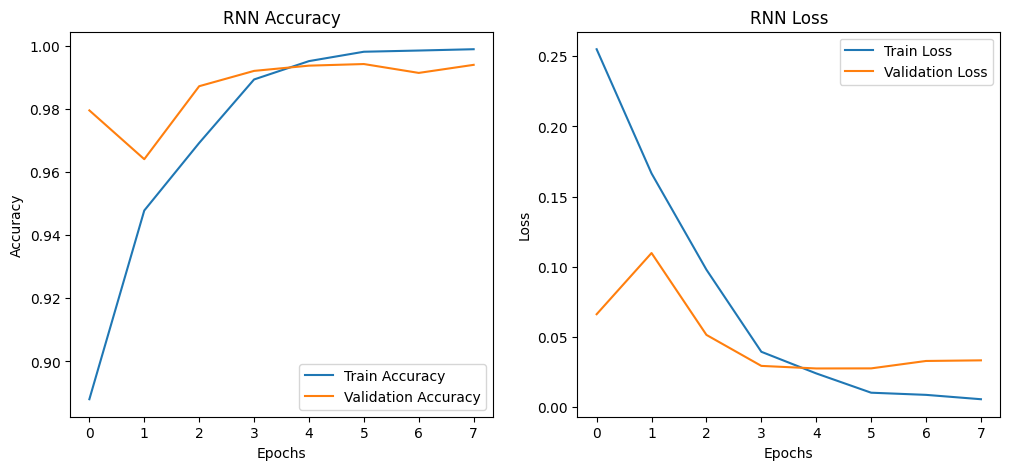

Final Test Accuracy: 0.9937


In [68]:
import pandas as pd
import numpy as np
import re
import string
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# === 1. Load Dataset ===
df = pd.read_csv("CEAS_08.csv")

# Drop missing values
df = df.dropna(subset=['body', 'subject', 'label'])

# Combine subject and body for analysis
df['text'] = df['subject'].fillna('') + " " + df['body'].fillna('')

# === 2. Preprocessing Function ===
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)  # remove numbers
    return text

df['clean_text'] = df['text'].apply(clean_text)

# === 3. Tokenization ===
max_words = 10000  # vocabulary size
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

# Save tokenizer for later use
joblib.dump(tokenizer, "tokenizer.pkl")

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Pad sequences
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

# Labels
y = df['label'].values

# === 4. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 5. Build RNN Model ===
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=maxlen))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# === 6. Compile Model ===
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# === 7. Train Model ===
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# === 8. Save Model ===
model.save("rnn_phishing_model.h5")
print("Model saved as rnn_phishing_model.h5")

# === 9. Plot Training Results ===
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# === 10. Final Test Accuracy ===
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Accuracy: {acc:.4f}")


[CEAS] Loaded 39139 rows, dropped 15 rows with invalid dates.
[OpenPhish] Requesting feed: https://openphish.com/feed.txt
[OpenPhish] Retrieved 300 URLs (date=2025-08-11).
[PhishTank] Attempting to scrape: https://phishtank.org/phish_search.php?valid=y&active=y&Search=Search
[PhishTank] Parsed 20 rows.
[Combined] rows: 22147
source
CEAS         21827
OpenPhish      300
PhishTank       20
dtype: int64


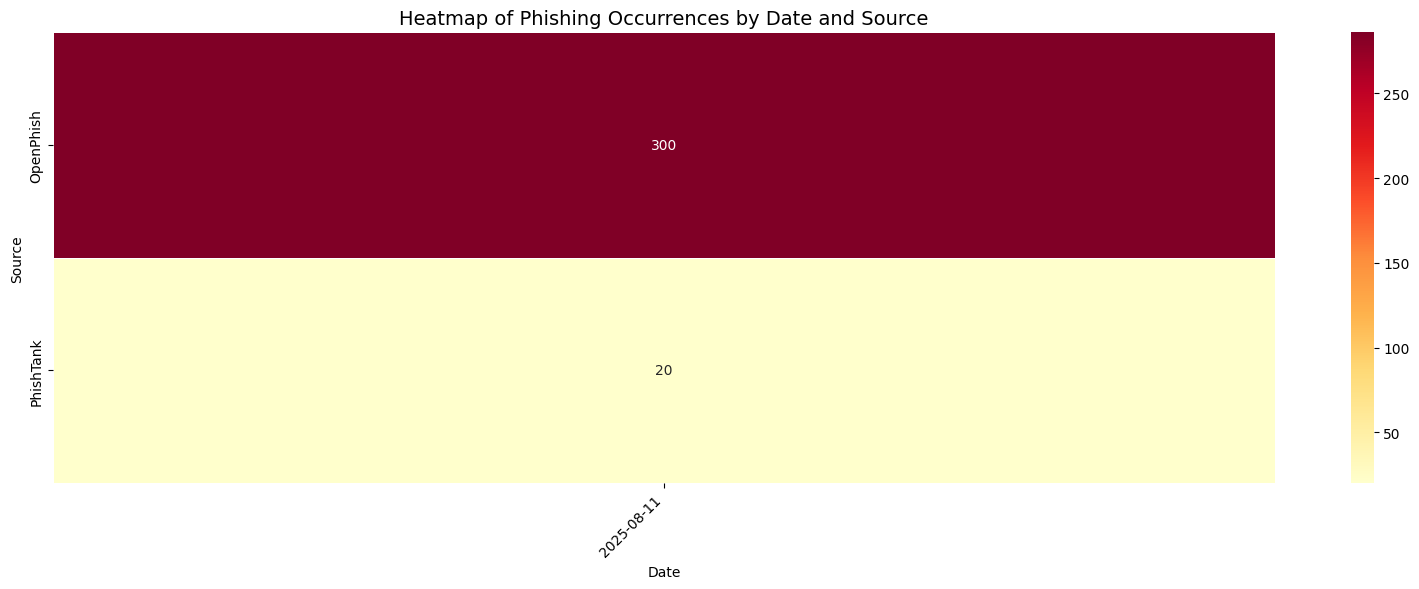

In [72]:
# heatmap_merged_phishing.py
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse
import datetime as dt
import sys
import warnings

warnings.filterwarnings("ignore")

def safe_parse_dates(series):
    """Try robust date parsing and return datetime.date series (drop non-parsable rows)."""
    # First try default parser
    parsed = pd.to_datetime(series, errors='coerce', utc=True)
    # For any remaining NaT, try stripping timezone text fragments or different formats:
    mask_nat = parsed.isna()
    if mask_nat.any():
        # Attempt to parse with dayfirst False/True fallback
        parsed2 = pd.to_datetime(series[mask_nat].astype(str), errors='coerce', dayfirst=True, utc=True)
        parsed.loc[mask_nat] = parsed2
    # Drop still-missing
    return parsed.dt.date  # will raise if not datetimelike; safe because parsed is datetime

def load_ceas(path="CEAS_08.csv"):
    df = pd.read_csv(path, dtype=str)  # read as string initially
    # Ensure expected columns exist
    required = {'date', 'label'}
    if not required.issubset(set(df.columns)):
        raise ValueError(f"CEAS file must contain columns: {required}. Found: {df.columns.tolist()}")
    # Try parse date
    df['parsed_date'] = safe_parse_dates(df['date'])
    before = len(df)
    df = df.dropna(subset=['parsed_date'])  # drop rows with unparseable dates
    dropped = before - len(df)
    print(f"[CEAS] Loaded {len(df)} rows, dropped {dropped} rows with invalid dates.")
    # Keep only phishing rows (label==1). CEAS uses numeric or string labels; normalize:
    df['label'] = df['label'].astype(str).str.strip()
    phish_mask = df['label'].isin(['1', 'True', 'true', 'phish', 'phishing'])
    df_phish = df[phish_mask].copy()
    df_phish['date'] = df_phish['parsed_date']  # date (datetime.date)
    df_phish['source'] = "CEAS"
    return df_phish[['date', 'source']]

def scrape_openphish(limit=None):
    """Scrape OpenPhish feed.txt (one URL per line). Assign today's date to each entry."""
    url = "https://openphish.com/feed.txt"
    print("[OpenPhish] Requesting feed:", url)
    try:
        r = requests.get(url, timeout=15)
        r.raise_for_status()
    except Exception as e:
        print("[OpenPhish] Failed to fetch:", e)
        return pd.DataFrame(columns=['date','source','url'])
    lines = [line.strip() for line in r.text.splitlines() if line.strip()]
    if limit:
        lines = lines[:limit]
    today = dt.date.today()
    df = pd.DataFrame({'url': lines})
    df['date'] = today
    df['source'] = 'OpenPhish'
    # optional: extract domain
    df['domain'] = df['url'].apply(lambda u: urlparse(u).netloc.lower())
    print(f"[OpenPhish] Retrieved {len(df)} URLs (date={today}).")
    return df[['date','source','url','domain']]

def try_scrape_phishtank(limit=200):
    """Attempt to scrape PhishTank public search page (best-effort). May fail if page structure changes."""
    url = "https://phishtank.org/phish_search.php?valid=y&active=y&Search=Search"
    print("[PhishTank] Attempting to scrape:", url)
    headers = {"User-Agent":"Mozilla/5.0"}
    try:
        r = requests.get(url, headers=headers, timeout=15)
        r.raise_for_status()
    except Exception as e:
        print("[PhishTank] Request failed:", e)
        return pd.DataFrame(columns=['date','source','url','domain'])
    soup = BeautifulSoup(r.text, 'html.parser')
    rows = soup.select("table tr")
    items = []
    for row in rows[1:]:
        cols = row.find_all("td")
        if len(cols) >= 3:
            raw_url = cols[1].get_text(strip=True)
            raw_date = cols[2].get_text(strip=True)
            # attempt to parse date for this row
            parsed = pd.to_datetime(raw_date, errors='coerce')
            date_val = pd.to_datetime(parsed).date() if not pd.isna(parsed) else dt.date.today()
            items.append((date_val, raw_url))
        if limit and len(items) >= limit:
            break
    if not items:
        print("[PhishTank] No items parsed (page may be structured differently).")
        return pd.DataFrame(columns=['date','source','url','domain'])
    df = pd.DataFrame(items, columns=['date','url'])
    df['source'] = 'PhishTank'
    df['domain'] = df['url'].apply(lambda u: urlparse(u).netloc.lower())
    print(f"[PhishTank] Parsed {len(df)} rows.")
    return df[['date','source','url','domain']]

def build_combined_frame(ceas_df, openphish_df=None, phishtank_df=None):
    parts = []
    if ceas_df is not None:
        parts.append(ceas_df.assign(url=np.nan, domain=np.nan))
    if openphish_df is not None and not openphish_df.empty:
        parts.append(openphish_df[['date','source','url','domain']])
    if phishtank_df is not None and not phishtank_df.empty:
        parts.append(phishtank_df[['date','source','url','domain']])
    if not parts:
        raise ValueError("No dataframes to combine.")
    combined = pd.concat(parts, ignore_index=True)
    # Normalize date type to datetime.date
    if not np.issubdtype(combined['date'].dtype, np.datetime64) and not isinstance(combined['date'].dtype, object):
        pass
    # If date values are datetime.date or datetime.datetime or strings, convert to date
    combined['date'] = pd.to_datetime(combined['date'], errors='coerce').dt.date
    before = len(combined)
    combined = combined.dropna(subset=['date'])
    after = len(combined)
    if before != after:
        print(f"[Combined] Dropped {before-after} rows with invalid dates after combining.")
    return combined

def aggregate_for_heatmap(df_combined, freq='D', start_date=None, end_date=None):
    """
    freq: 'D' for daily, 'W' for weekly aggregation
    returns pivoted DataFrame indexed by date with columns=source
    """
    # Optionally limit by date range
    if start_date:
        df_combined = df_combined[df_combined['date'] >= pd.to_datetime(start_date).date()]
    if end_date:
        df_combined = df_combined[df_combined['date'] <= pd.to_datetime(end_date).date()]
    # group by date and source
    grouped = df_combined.groupby(['date','source']).size().reset_index(name='count')
    pivot = grouped.pivot(index='date', columns='source', values='count').fillna(0).sort_index()
    # If freq != 'D', aggregate to that frequency (resample)
    if freq != 'D':
        # convert index to datetime64 for resampling
        pivot.index = pd.to_datetime(pivot.index)
        pivot = pivot.resample(freq).sum()
        pivot.index = pivot.index.date
    return pivot

def plot_heatmap(pivot_df, vmax=None, figsize=(14,6), annotate=True, cmap="Reds"):
    """Plot heatmap where rows are sources and columns are dates (transposed pivot)."""
    # transpose so sources are rows
    plot_df = pivot_df.T
    plt.figure(figsize=figsize)
    sns.heatmap(plot_df, cmap=cmap, linewidths=0.5, vmax=vmax, annot=annotate, fmt=".0f")
    plt.title("Heatmap of Phishing Occurrences by Date and Source", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Source")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # 1) Load historical CEAS dataset phishing rows
    try:
        ceas_phish_df = load_ceas("CEAS_08.csv")
    except Exception as e:
        print("Failed to load CEAS dataset:", e)
        ceas_phish_df = pd.DataFrame(columns=['date','source'])

    # 2) Scrape live OpenPhish (and optionally PhishTank)
    openphish_df = scrape_openphish(limit=500)  # limit to 500 for speed; set None to fetch all
    phishtank_df = try_scrape_phishtank(limit=200)  # best-effort

    # 3) Combine
    combined = build_combined_frame(ceas_phish_df, openphish_df=openphish_df, phishtank_df=phishtank_df)
    print("[Combined] rows:", len(combined))
    print(combined.groupby('source').size())

    # 4) Aggregate for heatmap daily; optionally restrict to last N days
    # Choose date window: last 30 days for live data + entire CEAS history (or adjust)
    end = dt.date.today()
    start = end - dt.timedelta(days=30)  # change as needed
    pivot_daily = aggregate_for_heatmap(combined, freq='D', start_date=start, end_date=end)

    if pivot_daily.empty:
        print("No data to plot for given date range. Try expanding start/end or check inputs.")
        sys.exit(0)

    # 5) Plot heatmap
    # set vmax to  the 95th percentile to avoid outlier dominance
    vmax = pivot_daily.values.max() if pivot_daily.values.max() <= 10 else np.percentile(pivot_daily.values, 95)
    plot_heatmap(pivot_daily, vmax=vmax, figsize=(16,6), annotate=True, cmap="YlOrRd")


In [73]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# ==== 1. Load dataset ====
df = pd.read_csv("CEAS_08.csv")  # Example dataset
df = df.dropna(subset=['body', 'label'])  # Ensure no NaNs

X_text = df['body'].astype(str).values
y = df['label'].astype(int).values

# ==== 2. Tokenization & Padding ====
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_text)
X_seq = tokenizer.texts_to_sequences(X_text)
X_pad = pad_sequences(X_seq, maxlen=200)

# ==== 3. Define model creation function ====
def create_model(input_length, vocab_size):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=input_length))
    model.add(Bidirectional(GRU(64, return_sequences=False)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# ==== 4. K-Fold Cross-Validation ====
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_pad), 1):
    print(f"=== Fold {fold} ===")
    X_train, X_val = X_pad[train_idx], X_pad[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = create_model(input_length=200, vocab_size=10000)
    model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)
    
    # Evaluate
    y_pred = (model.predict(X_val) > 0.5).astype(int)
    acc = accuracy_score(y_val, y_pred)
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    fold_accuracies.append(acc)

print("\nMean Accuracy:", np.mean(fold_accuracies))
print("Standard Deviation:", np.std(fold_accuracies))


=== Fold 1 ===
Epoch 1/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 119s 225ms/step - accuracy: 0.9714 - loss: 0.0704
Epoch 2/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 184s 377ms/step - accuracy: 0.9959 - loss: 0.0158
Epoch 3/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 110s 224ms/step - accuracy: 0.9981 - loss: 0.0080
Epoch 4/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 110s 225ms/step - accuracy: 0.9987 - loss: 0.0061
Epoch 5/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 113s 230ms/step - accuracy: 0.9981 - loss: 0.0081
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step
Fold 1 Accuracy: 0.9941
=== Fold 2 ===
Epoch 1/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 119s 232ms/step - accuracy: 0.9713 - loss: 0.0746
Epoch 2/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 111s 225ms/step - accuracy: 0.9954 - loss: 0.0184
Epoch 3/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 112s 228ms/step - accuracy: 0.9977 - loss: 0.0100
Epoch 4/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 174s 356ms/step - accuracy: 0.9982 - loss: 0.0075
Epoch 5/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 142s 289ms/step - accuracy: 0.9987 - loss: 0.0060
245/245 ━━━━━

### Analysis of the Number of Words to Enter the Algorithm

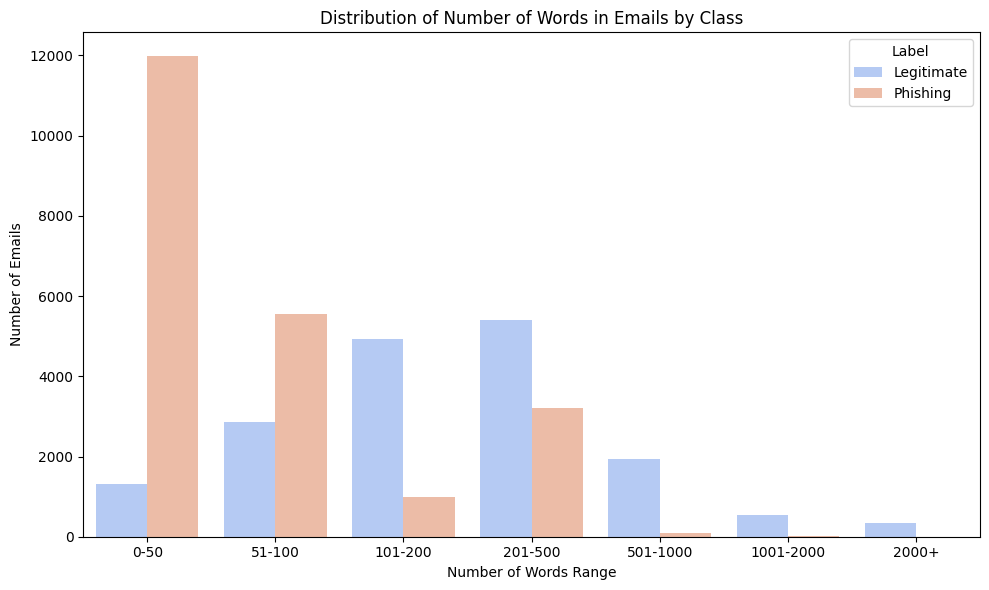

         count        mean         std  min    25%    50%     75%      max
label                                                                     
0      17312.0  351.144120  682.744113  1.0  102.0  187.0  355.25  19863.0
1      21842.0   83.850838  108.845954  1.0   20.0   42.0   90.00   1903.0


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Load dataset ===
df = pd.read_csv("CEAS_08.csv")  # adjust if needed
df = df.dropna(subset=['body', 'label'])

# === 2. Count words ===
df['word_count'] = df['body'].apply(lambda x: len(str(x).split()))

# === 3. Create bins ===
bins = [0, 50, 100, 200, 500, 1000, 2000, max(df['word_count'])]
labels = ["0-50", "51-100", "101-200", "201-500", "501-1000", "1001-2000", "2000+"]
df['word_bin'] = pd.cut(df['word_count'], bins=bins, labels=labels, right=False)

# === 4. Plot distribution by label ===
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='word_bin', hue='label', palette='coolwarm')
plt.title("Distribution of Number of Words in Emails by Class")
plt.xlabel("Number of Words Range")
plt.ylabel("Number of Emails")
plt.legend(title="Label", labels=["Legitimate", "Phishing"])
plt.tight_layout()
plt.show()

# === 5. Summary statistics ===
summary = df.groupby('label')['word_count'].describe()
print(summary)


In [76]:
# === Stopwords Removal for Phishing Detection ===

import pandas as pd
from nltk.corpus import stopwords
import nltk

# Download stopwords if not already available
nltk.download('stopwords')

# Example phishing email text
phishing_text = "congratulations you are the brand new bill gates lottery winner send us your account number to transfer the money to you"

# Convert to list of words
words = phishing_text.split()

# Define English stopwords set
stop_words = set(stopwords.words('english'))

# Remove stopwords
filtered_words = [word for word in words if word.casefold() not in stop_words]

# Print results
print("Original Words:", words)
print("Filtered Words:", filtered_words)

# === Example for a dataset ===
# Load dataset (CEAS or other phishing dataset)
df = pd.read_csv("CEAS_08.csv")  # adjust filename if needed
df = df.dropna(subset=['body'])  # ensure no NaN in text

# Apply stopwords removal to email body
def remove_stopwords(text):
    words = str(text).split()
    return ' '.join([word for word in words if word.casefold() not in stop_words])

df['body_no_stopwords'] = df['body'].apply(remove_stopwords)

# Show before & after example
print("\n--- Before Stopwords Removal ---")
print(df['body'].iloc[0])
print("\n--- After Stopwords Removal ---")
print(df['body_no_stopwords'].iloc[0])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\azad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Original Words: ['congratulations', 'you', 'are', 'the', 'brand', 'new', 'bill', 'gates', 'lottery', 'winner', 'send', 'us', 'your', 'account', 'number', 'to', 'transfer', 'the', 'money', 'to', 'you']
Filtered Words: ['congratulations', 'brand', 'new', 'bill', 'gates', 'lottery', 'winner', 'send', 'us', 'account', 'number', 'transfer', 'money']

--- Before Stopwords Removal ---
Buck up, your troubles caused by small dimension will soon be over!
Become a lover no woman will be able to resist!
http://whitedone.com/


come. Even as Nazi tanks were rolling down the streets, the dreamersphilosopher or a journalist. He was still not sure.I do the same.

--- After Stopwords Removal ---
Buck up, troubles caused small dimension soon over! Become lover woman able resist! http://whitedone.com/ come. Even Nazi tanks rolling streets, dreamersphilosopher journalist. still sure.I same.
